In [26]:

%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np


import matplotlib.pyplot as plt
from matplotlib import pyplot
import matplotlib 
import matplotlib.cm as cm
import matplotlib.animation as animation
import matplotlib.gridspec as gridspec
from matplotlib.legend_handler import HandlerPatch
import matplotlib.patches as mpatches
import seaborn as sns
import matplotlib as mpl
import pickle as pkl
import os
#from kcrf.estimator import simple_estimator as np_simple_est
import time 
import csv
import torch
from torch.autograd import Variable
import torch.optim as optim
from copy import deepcopy
import pandas as pd
import hydra
from helpers import *
from matplotlib.colors import hsv_to_rgb
import matplotlib.colors as mpl_colors
from math import log10

from hydra.core.hydra_config import HydraConfig
from omegaconf import DictConfig, ListConfig, OmegaConf
from Experimentalist.reader import Reader
import json
#from Experimentalist.utils import load_dict_from_json
from sympy import latex, sympify, Symbol
from Experimentalist.utils import group_by, aggregate, safe_argmin, safe_argmax


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [28]:
def safeargmin(a):
    try:
        return np.nanargmin(a)
    except:
        return -1
def safeargmax(a):
    try:
        return np.nanargmax(a)
    except:
        return -1
def reduced_dict_to_list_dicts(out_dict, index, key):
    out = []
    for method in out_dict.keys():
        if len(out_dict[method][key])>index:
            out.append(out_dict[method][key][index])
    return out

def aggregate_paths_in_config_dicts(out_dict, key):
    out = []
    for method in out_dict.keys():
            cur_dict = copy.deepcopy(out_dict[method][key][0])
            cur_dict['logs']['log_id'] = [ p['logs']['log_id'] for p in out_dict[method][key]]
            out.append(cur_dict)
    return out

def make_paths_to_seeds(aggregate_dict, res_key):
    out = []
    for method, p in aggregate_dict.items():
        for keys, values in p.items():
            
            
            cur_dict = copy.deepcopy(values['refs'][res_key][0])
            cur_dict['logs']['path'] = [ p['logs']['path'] for p in values['refs'][res_key]]
            out.append(cur_dict)  
    return out
def make_plot_dicts(methods,key_name):
    labels = {m: key_name +' ' +m  for m in methods}
    colors = sns.color_palette("colorblind", n_colors=len(methods), desat=.7)
    sns.palplot(colors)
    color_dict_index = {m:i for i,m in enumerate(methods)}
    color_dict = {key:colors[value] for key,value in color_dict_index.items()}
    linestyles = {m:'-' for m in methods}
    return color_dict,labels,linestyles, colors


def make_paths_to_seeds(aggregate_dict, res_key):
    out = []
    for method, p in aggregate_dict.items():
        for keys, values in p.items():
            
            
            cur_dict = copy.deepcopy(values['refs'][res_key][0])
            cur_dict['logs']['path'] = [ p['logs']['path'] for p in values['refs'][res_key]]
            out.append(cur_dict)  
    return out

def op_aggregate_paths(res_dict):

    if res_dict:
        out = copy.deepcopy(res_dict[0])
        out['logs']['path'] = [p['logs']['path'] for p in res_dict]
        return [out]
    else:
        return res_dict

def make_gens(list_config_dicts,ynames,group_key,xname='epoch'):
    gen_list= []
    for yname in ynames:
        gen = extract_xy_data_from_configs(
        list_config_dicts,
        yname= yname,
        group_key=group_key,
        xname=xname, 
        relative_error= False,
        avg_time_dict=None)
        gen_list.append(list(gen))
    return gen_list
    

In [29]:
def save(n, ext='.pdf', save_figs=True,dirname = '../data/figures', **kwargs):
    if save_figs==True:
        kwargs.setdefault('bbox_inches', 'tight')
        kwargs.setdefault('pad_inches', 0.1)
        kwargs.setdefault('transparent', True)
        plt.savefig(os.path.join(dirname, n + ext), **kwargs)
        
    

In [39]:
log_name = 'multitask_cifar100'
out_dir = '../data/outputs'
reader = Reader(os.path.join(out_dir,log_name))



In [40]:
query = {'selection.name' : ["BGS"],
        'selection.linear_solver.lr': [0.001],
        'selection.optimizer.lr': [0.1],
        'selection.linear_op.stochastic':[True],
         'selection.linear_op.compute_new_grad':[True],
        }



out = reader.search(query)

query = {'selection.name' : ["BGS"],
        'selection.linear_solver.lr': [0.001],
        'selection.optimizer.lr': [0.1],
        'selection.linear_op.stochastic':[False],
        }


out = reader.search(query)


len(out)


8

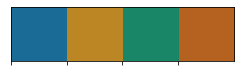

In [41]:
val_keys = ['train_upper_loss','train_upper_acc','test_upper_loss_all','test_upper_acc_all']
failed_exps = []
for i,p in enumerate(out):
    try:
        add_res_to_data(p, val_keys, mode='last')
    except:
        failed_exps.append(i)

out = [p  for i,p in enumerate(out) if i not in  failed_exps]
group_keys = [('selection','linear_op','stochastic'),('selection','linear_op','compute_new_grad'),
              ('selection','linear_op','use_new_input')]

group_keys = [('selection','linear_op','compute_new_grad'),
              ('selection','compute_latest_correction'),
             ('selection','linear_op','stochastic')]

#group_keys = [('selection','optimizer','lr')]
#variable_keys = [('data','b_size')]
variable_keys = [('training','total_epoch')]
#variable_keys = [('solver','inner_forward','n_iter')]

value_keys = [('results','train_upper_loss'),('results','train_upper_acc')]
aggregate_dict = aggregate_res_dict(out,group_keys, variable_keys, value_keys)
reduced_dict = reduce_res_dict(aggregate_dict, [safeargmin,safeargmax],variable_keys,sort=True, is_index=True)
list_config_dicts = reduced_dict_to_list_dicts(reduced_dict, 0, 'index_results_train_upper_loss')
methods = reduced_dict.keys()
key_name = '-'.join([el[-1] for el in group_keys])+':'

color_dict, labels_dict, linestyles_dict,colors = make_plot_dicts(methods,key_name)


In [43]:
for i in range(4):
    print(list_config_dicts[i]['results']['train_upper_loss'])
    print(list_config_dicts[i]['logs']['log_id'])

nan
9
nan
12
0.008867260068655014
13
0.1317933201789856
16


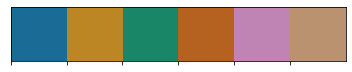

In [23]:
val_keys = ['train_upper_loss','train_upper_acc','test_upper_loss_all','test_upper_acc_all']
failed_exps = []
for i,p in enumerate(out):
    try:
        add_res_to_data(p, val_keys, mode='last')
    except:
        failed_exps.append(i)

out = [p  for i,p in enumerate(out) if i not in  failed_exps]

group_keys = [[('selection','linear_op','compute_new_grad'),
              ('selection','compute_latest_correction'),
             ('selection','linear_op','stochastic')],
             [('training','total_epoch')]]

#group_keys = [('selection','optimizer','lr')]
#variable_keys = [('data','b_size')]
#variable_keys = [('solver','inner_forward','n_iter')]

value_keys = [('results','train_upper_loss'),('results','train_upper_acc')]
collection = group_by(out,group_keys)
reduced_dict = aggregate(collection, value_keys,[safe_argmin,safe_argmax])
list_config_dicts = reduce_collection_to_list(reduced_dict,'index_results_train_upper_loss')
group_keys = group_keys[0]
methods = reduced_dict.keys()
key_name = '-'.join([el[-1] for el in group_keys])+':'

color_dict, labels_dict, linestyles_dict,colors = make_plot_dicts(methods,key_name)


In [24]:
for dico in list_config_dicts:
    print(dico['logs']['log_id'])

2
4
9
12
13
16


/tmp/ipykernel_21495/2387618682.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels(['{:,.0%}'.format(x/100.) for x in vals])
/tmp/ipykernel_21495/2387618682.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_yticklabels(['{:,.0%}'.format(x/100.) for x in vals])


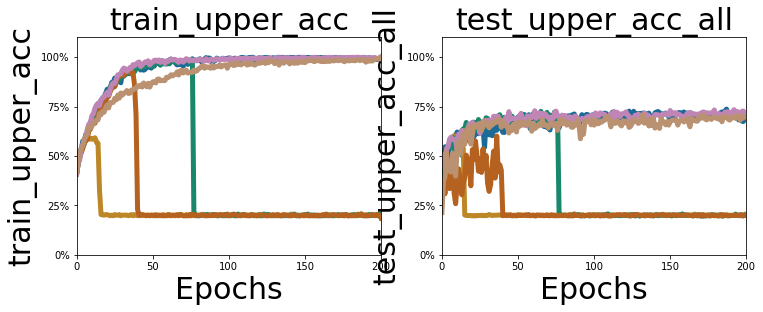

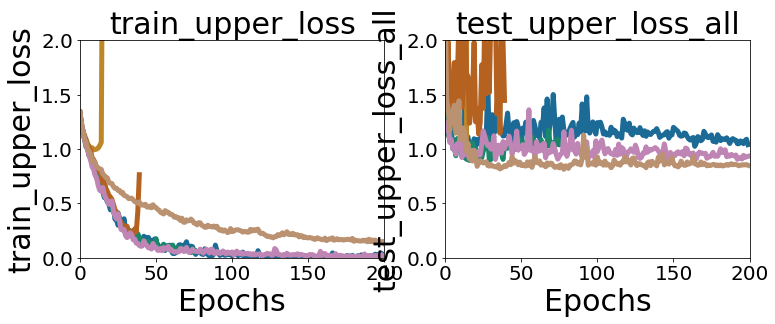

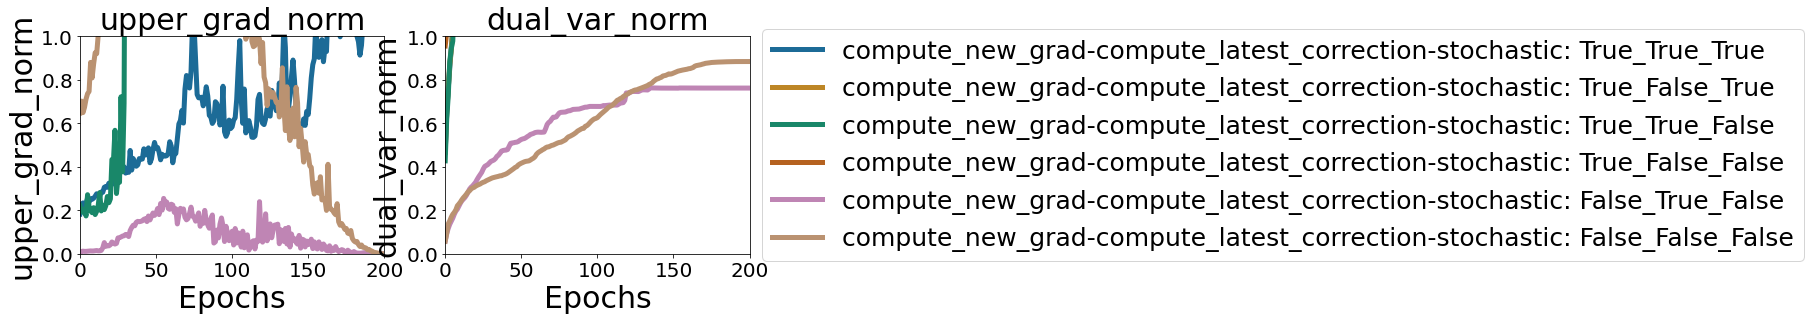

In [18]:
num_x =2
num_y = 1
avg_time_dict = None
xlabel = ''
ylabel = ''
title  = ''
xlim= [0,200]
ylim = [0,110.]
xlabel = 'Epochs'

ynames = ['train_upper_acc','test_upper_acc_all']
gen_list = make_gens(list_config_dicts,ynames,group_keys)
fig, ax = plt.subplots(num_y,num_x, figsize=(6*num_x,4*num_y))
for i,(gen,yname) in enumerate(zip(gen_list,ynames)):
    plot_from_config(ax[i],
                 gen,
                 color_dict,
                 labels_dict,
                 linestyles_dict,
                 xscale='linear',
                 yscale = 'linear',
                 ylabel=yname,
                 xlabel= 'Epochs',
                 title= yname ,
                 fontsize=30,
                 xlim=xlim,
                 ylim= ylim,
                 ticks_fontsize=20,
                 with_legend=False)



vals = ax[1].get_yticks()
ax[1].set_yticklabels(['{:,.0%}'.format(x/100.) for x in vals])
vals = ax[0].get_yticks()
ax[0].set_yticklabels(['{:,.0%}'.format(x/100.) for x in vals])

#handles, labels = ax[0].get_legend_handles_labels()
#ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5),prop={"size":25})

ynames = ['train_upper_loss','test_upper_loss_all']
ylim = [0,2.]
gen_list = make_gens(list_config_dicts,ynames,group_keys)
fig, ax = plt.subplots(num_y,num_x, figsize=(6*num_x,4*num_y))
for i,(gen,yname) in enumerate(zip(gen_list,ynames)):
    plot_from_config(ax[i],
                 gen,
                 color_dict,
                 labels_dict,
                 linestyles_dict,
                 xscale='linear',
                 yscale = 'linear',
                 ylabel=yname,
                 xlabel= 'Epochs',
                 title= yname ,
                 fontsize=30,
                 xlim=xlim,
                 ylim= ylim,
                 ticks_fontsize=20,
                 with_legend=False)



#handles, labels = ax[0].get_legend_handles_labels()
#ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5),prop={"size":25})

ynames = ['upper_grad_norm','dual_var_norm']
ylim = [0,1.]
gen_list = make_gens(list_config_dicts,ynames,group_keys)
fig, ax = plt.subplots(num_y,num_x, figsize=(6*num_x,4*num_y))
for i,(gen,yname) in enumerate(zip(gen_list,ynames)):
    plot_from_config(ax[i],
                 gen,
                 color_dict,
                 labels_dict,
                 linestyles_dict,
                 xscale='linear',
                 yscale = 'linear',
                 ylabel=yname,
                 xlabel= 'Epochs',
                 title= yname ,
                 fontsize=30,
                 xlim=xlim,
                 ylim= ylim,
                 ticks_fontsize=20,
                 with_legend=False)



handles, labels = ax[0].get_legend_handles_labels()
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5),prop={"size":25})



#plt.tight_layout()





fig_name = 'multitask_cifar100_lr_0.001'
save(fig_name)


In [1344]:
query = {'training.trainer_name' : ["examples.multitask.trainer.Trainer"],
        'selection.optimizer.lr': [0.1],}

out = reader.search(query)
#color_dict, labels_dict, linestyles_dict,colors = make_plot_dicts(out)
len(out)


34

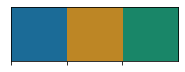

In [1345]:
val_keys = ['train_upper_loss','train_upper_acc','test_upper_loss_all','test_upper_acc_all']
failed_exps = []
for i,p in enumerate(out):
    try:
        add_res_to_data(p, val_keys, mode='last')
    except:
        failed_exps.append(i)

out = [p  for i,p in enumerate(out) if i not in  failed_exps]
group_keys = [('selection','linear_op','stochastic'),('selection','linear_op','compute_new_grad'),
              ('selection','linear_op','use_new_input')]

group_keys = [('selection','name')]

#group_keys = [('selection','optimizer','lr')]
#variable_keys = [('data','b_size')]
variable_keys = [('training','total_epoch')]
#variable_keys = [('solver','inner_forward','n_iter')]

value_keys = [('results','train_upper_loss'), ('results','test_upper_loss_all'),('results','train_upper_acc'),('results','test_upper_acc_all')]
apply_func = [safeargmin,safeargmin, safeargmax,safeargmax]
aggregate_dict = aggregate_res_dict(out,group_keys, variable_keys, value_keys)
reduced_dict = reduce_res_dict(aggregate_dict, apply_func,variable_keys,sort=True, is_index=True)
list_config_dicts = reduced_dict_to_list_dicts(reduced_dict, 0, 'index_results_'+value_keys[0][1])
methods = reduced_dict.keys()
key_name = '-'.join([el[-1] for el in group_keys])+':'

color_dict, labels_dict, linestyles_dict,colors = make_plot_dicts(methods,key_name)


In [ ]:
val_keys = ['train_upper_loss','train_upper_acc','test_upper_loss_all','test_upper_acc_all']
failed_exps = []
for i,p in enumerate(out):
    try:
        add_res_to_data(p, val_keys, mode='last')
    except:
        failed_exps.append(i)

out = [p  for i,p in enumerate(out) if i not in  failed_exps]
group_keys = [('selection','linear_op','stochastic'),('selection','linear_op','compute_new_grad'),
              ('selection','linear_op','use_new_input')]

group_keys = [('selection','name')]

#group_keys = [('selection','optimizer','lr')]
#variable_keys = [('data','b_size')]
variable_keys = [('training','total_epoch')]
#variable_keys = [('solver','inner_forward','n_iter')]

value_keys = [('results','train_upper_loss'), ('results','test_upper_loss_all'),('results','train_upper_acc'),('results','test_upper_acc_all')]
apply_func = [safeargmin,safeargmin, safeargmax,safeargmax]
aggregate_dict = aggregate_res_dict(out,group_keys, variable_keys, value_keys)
reduced_dict = reduce_res_dict(aggregate_dict, apply_func,variable_keys,sort=True, is_index=True)
list_config_dicts = reduced_dict_to_list_dicts(reduced_dict, 0, 'index_results_'+value_keys[0][1])
methods = reduced_dict.keys()
key_name = '-'.join([el[-1] for el in group_keys])+':'

color_dict, labels_dict, linestyles_dict,colors = make_plot_dicts(methods,key_name)


/tmp/ipykernel_11510/2217834120.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels(['{:,.0%}'.format(x/100.) for x in vals])
/tmp/ipykernel_11510/2217834120.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_yticklabels(['{:,.0%}'.format(x/100.) for x in vals])


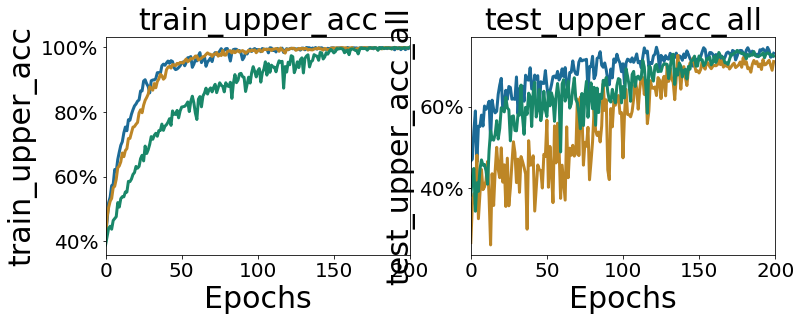

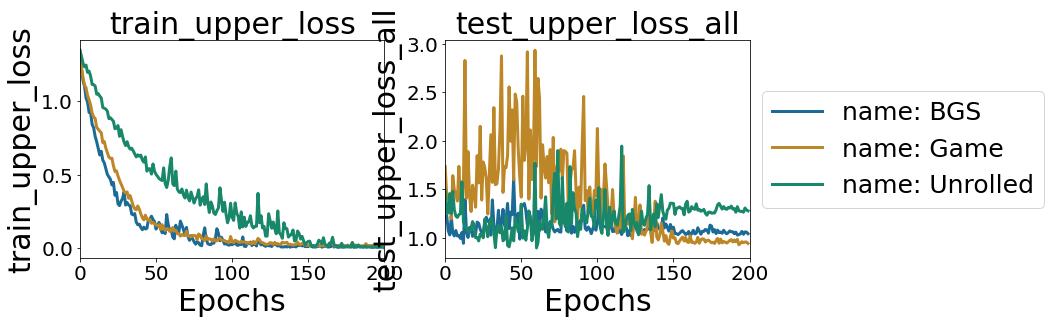

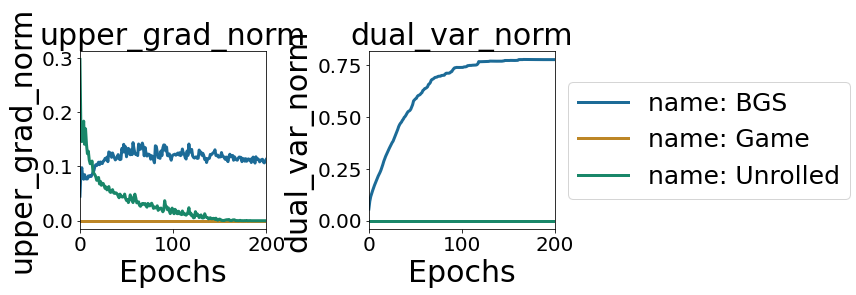

In [1346]:
num_x =2
num_y = 1
avg_time_dict = None
xlabel = ''
ylabel = ''
title  = ''
xlim= [0,200]
ylim = [20,80.]
xlabel = 'Epochs'
lw = 3.
ynames = ['train_upper_acc','test_upper_acc_all']
gen_list = make_gens(list_config_dicts,ynames,group_keys)
fig, ax = plt.subplots(num_y,num_x, figsize=(6*num_x,4*num_y))
for i,(gen,yname) in enumerate(zip(gen_list,ynames)):
    plot_from_config(ax[i],
                 gen,
                 color_dict,
                 labels_dict,
                 linestyles_dict,
                 xscale='linear',
                 yscale = 'linear',
                 ylabel=yname,
                 xlabel= 'Epochs',
                 title= yname ,
                 fontsize=30,
                 xlim=xlim,
                 ylim= None,
                 ticks_fontsize=20,
                 lw=lw,
                 with_legend=False)



vals = ax[1].get_yticks()
ax[1].set_yticklabels(['{:,.0%}'.format(x/100.) for x in vals])
vals = ax[0].get_yticks()
ax[0].set_yticklabels(['{:,.0%}'.format(x/100.) for x in vals])

#handles, labels = ax[0].get_legend_handles_labels()
#ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5),prop={"size":25})

ynames = ['train_upper_loss','test_upper_loss_all']
ylim = [0,2.]
gen_list = make_gens(list_config_dicts,ynames,group_keys)
fig, ax = plt.subplots(num_y,num_x, figsize=(6*num_x,4*num_y))
for i,(gen,yname) in enumerate(zip(gen_list,ynames)):
    plot_from_config(ax[i],
                 gen,
                 color_dict,
                 labels_dict,
                 linestyles_dict,
                 xscale='linear',
                 yscale = 'linear',
                 ylabel=yname,
                 xlabel= 'Epochs',
                 title= yname ,
                 fontsize=30,
                 xlim=xlim,
                 ylim= None,
                 ticks_fontsize=20,
                 lw=lw,
                 with_legend=False)



handles, labels = ax[0].get_legend_handles_labels()
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5),prop={"size":25})

ynames = ['upper_grad_norm','dual_var_norm']
ylim = [0,1.]
gen_list = make_gens(list_config_dicts,ynames,group_keys)
fig, ax = plt.subplots(num_y,num_x, figsize=(6*num_x,4*num_y))
for i,(gen,yname) in enumerate(zip(gen_list,ynames)):
    plot_from_config(ax[i],
                 gen,
                 color_dict,
                 labels_dict,
                 linestyles_dict,
                 xscale='linear',
                 yscale = 'linear',
                 ylabel=yname,
                 xlabel= 'Epochs',
                 title= yname ,
                 fontsize=30,
                 xlim=xlim,
                 ylim= None,
                 ticks_fontsize=20,
                 lw=lw,
                 with_legend=False)



handles, labels = ax[0].get_legend_handles_labels()
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5),prop={"size":25})



plt.tight_layout()





fig_name = 'multitask_cifar100_total'
save(fig_name)


In [1347]:
ynames = ['train_upper_acc','test_upper_acc_all']
#ynames = ['train_upper_loss','test_upper_loss_all']
gen_list = make_gens(list_config_dicts,ynames,group_keys)
gen_list[1][0]['y'][-1]

73.1249988079071

In [1348]:

log_name = 'multitask_cifar100_scheduling_weight_decay'
out_dir = '../data/outputs'
reader = load_method(log_name,out_dir)

query = {'training.trainer_name' : ["examples.multitask.trainer.Trainer"],
        'training.upper.scheduler.use_scheduler': [True],
        }

out = reader.search(query)
#color_dict, labels_dict, linestyles_dict,colors = make_plot_dicts(out)
len(out)

11

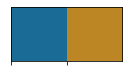

In [1349]:
val_keys = ['train_upper_loss','train_upper_acc','test_upper_loss_all','test_upper_acc_all']
failed_exps = []
for i,p in enumerate(out):
    try:
        add_res_to_data(p, val_keys, mode='last')
    except:
        failed_exps.append(i)

out = [p  for i,p in enumerate(out) if i not in  failed_exps]
group_keys = [('selection','linear_op','stochastic'),('selection','linear_op','compute_new_grad'),
              ('selection','linear_op','use_new_input')]

group_keys = [('selection','name')]

#group_keys = [('selection','optimizer','lr')]
#variable_keys = [('data','b_size')]
variable_keys = [('training','total_epoch')]
#variable_keys = [('solver','inner_forward','n_iter')]

value_keys = [('results','train_upper_loss'), ('results','test_upper_loss_all'),('results','train_upper_acc'),('results','test_upper_acc_all')]
apply_func = [safeargmin,safeargmin, safeargmax,safeargmax]
aggregate_dict = aggregate_res_dict(out,group_keys, variable_keys, value_keys)
reduced_dict = reduce_res_dict(aggregate_dict, apply_func,variable_keys,sort=True, is_index=True)
list_config_dicts = reduced_dict_to_list_dicts(reduced_dict, 0, 'index_results_'+value_keys[3][1])
methods = reduced_dict.keys()
key_name = '-'.join([el[-1] for el in group_keys])+':'

color_dict, labels_dict, linestyles_dict,colors = make_plot_dicts(methods,key_name)


/tmp/ipykernel_11510/2217834120.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels(['{:,.0%}'.format(x/100.) for x in vals])
/tmp/ipykernel_11510/2217834120.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_yticklabels(['{:,.0%}'.format(x/100.) for x in vals])


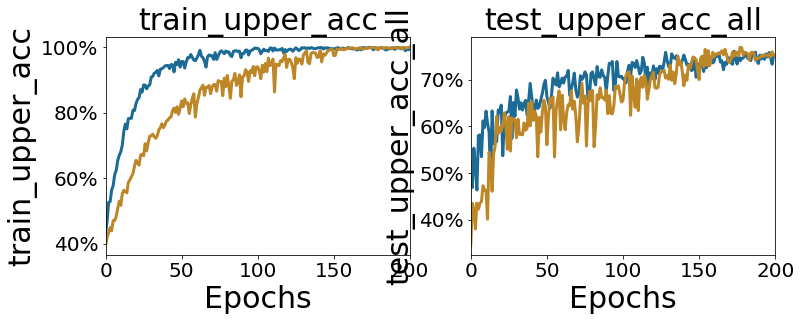

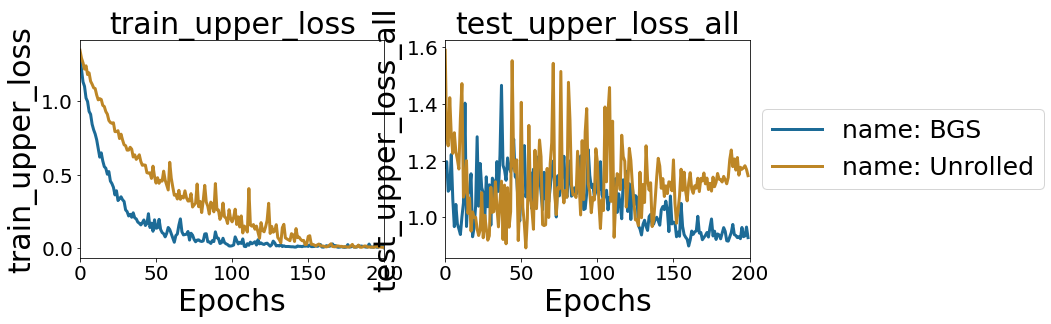

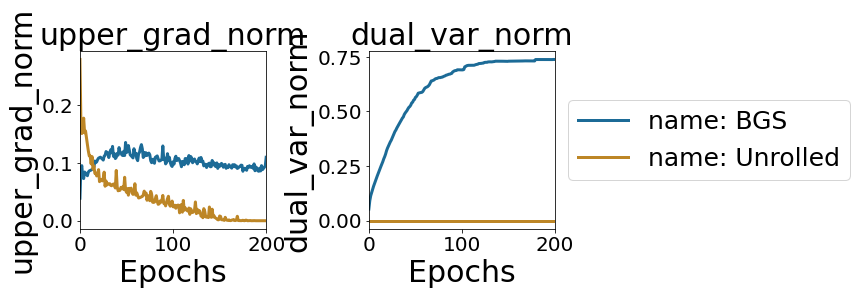

In [1350]:
num_x =2
num_y = 1
avg_time_dict = None
xlabel = ''
ylabel = ''
title  = ''
xlim= [0,200]
ylim = [20,80.]
xlabel = 'Epochs'
lw = 3.
ynames = ['train_upper_acc','test_upper_acc_all']
gen_list = make_gens(list_config_dicts,ynames,group_keys)
fig, ax = plt.subplots(num_y,num_x, figsize=(6*num_x,4*num_y))
for i,(gen,yname) in enumerate(zip(gen_list,ynames)):
    plot_from_config(ax[i],
                 gen,
                 color_dict,
                 labels_dict,
                 linestyles_dict,
                 xscale='linear',
                 yscale = 'linear',
                 ylabel=yname,
                 xlabel= 'Epochs',
                 title= yname ,
                 fontsize=30,
                 xlim=xlim,
                 ylim= None,
                 ticks_fontsize=20,
                 lw=lw,
                 with_legend=False)



vals = ax[1].get_yticks()
ax[1].set_yticklabels(['{:,.0%}'.format(x/100.) for x in vals])
vals = ax[0].get_yticks()
ax[0].set_yticklabels(['{:,.0%}'.format(x/100.) for x in vals])

#handles, labels = ax[0].get_legend_handles_labels()
#ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5),prop={"size":25})

ynames = ['train_upper_loss','test_upper_loss_all']
ylim = [0,2.]
gen_list = make_gens(list_config_dicts,ynames,group_keys)
fig, ax = plt.subplots(num_y,num_x, figsize=(6*num_x,4*num_y))
for i,(gen,yname) in enumerate(zip(gen_list,ynames)):
    plot_from_config(ax[i],
                 gen,
                 color_dict,
                 labels_dict,
                 linestyles_dict,
                 xscale='linear',
                 yscale = 'linear',
                 ylabel=yname,
                 xlabel= 'Epochs',
                 title= yname ,
                 fontsize=30,
                 xlim=xlim,
                 ylim= None,
                 ticks_fontsize=20,
                 lw=lw,
                 with_legend=False)



handles, labels = ax[0].get_legend_handles_labels()
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5),prop={"size":25})

ynames = ['upper_grad_norm','dual_var_norm']
ylim = [0,1.]
gen_list = make_gens(list_config_dicts,ynames,group_keys)
fig, ax = plt.subplots(num_y,num_x, figsize=(6*num_x,4*num_y))
for i,(gen,yname) in enumerate(zip(gen_list,ynames)):
    plot_from_config(ax[i],
                 gen,
                 color_dict,
                 labels_dict,
                 linestyles_dict,
                 xscale='linear',
                 yscale = 'linear',
                 ylabel=yname,
                 xlabel= 'Epochs',
                 title= yname ,
                 fontsize=30,
                 xlim=xlim,
                 ylim= None,
                 ticks_fontsize=20,
                 lw=lw,
                 with_legend=False)



handles, labels = ax[0].get_legend_handles_labels()
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5),prop={"size":25})



plt.tight_layout()





fig_name = 'multitask_cifar100_total'
save(fig_name)


In [1351]:
ynames = ['train_upper_acc','test_upper_acc_all']
ynames = ['train_upper_loss','test_upper_loss_all']
gen_list = make_gens(list_config_dicts,ynames,group_keys)
gen_list[1][0]['y'][-1]

i = np.argmin(gen_list[0][0]['y'], axis=0)
i

200

In [1352]:
log_name = 'distillation_cifar10'
out_dir = '../data/outputs'
reader = load_method(log_name,out_dir)

query = {'training.lower.model.name': ['torchvision.models.resnet18'],
        }

out = reader.search(query)
#color_dict, labels_dict, linestyles_dict,colors = make_plot_dicts(out)
len(out)

39

[Errno 2] No such file or directory: '/home/marbel/Documents/projects/BGS-opt/data/outputs/distillation_cifar10/23/metrics.json'
[Errno 2] No such file or directory: '/home/marbel/Documents/projects/BGS-opt/data/outputs/distillation_cifar10/24/metrics.json'
[Errno 2] No such file or directory: '/home/marbel/Documents/projects/BGS-opt/data/outputs/distillation_cifar10/25/metrics.json'
[Errno 2] No such file or directory: '/home/marbel/Documents/projects/BGS-opt/data/outputs/distillation_cifar10/26/metrics.json'
[Errno 2] No such file or directory: '/home/marbel/Documents/projects/BGS-opt/data/outputs/distillation_cifar10/30/metrics.json'


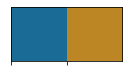

In [1353]:
val_keys = ['train_upper_loss','train_upper_acc','test_upper_loss','test_upper_acc']
failed_exps = []
for i,p in enumerate(out):
    try:
        add_res_to_data(p, val_keys, mode='last')
    except:
        failed_exps.append(i)

out = [p  for i,p in enumerate(out) if i not in  failed_exps]


group_keys = [('selection','correction')]

#group_keys = [('selection','optimizer','lr')]
#variable_keys = [('data','b_size')]
variable_keys = [('training','total_epoch')]
variable_keys = [('training','lower','model','name')]

#variable_keys = [('solver','inner_forward','n_iter')]

value_keys = [('results','train_upper_loss'), ('results','test_upper_loss'),('results','train_upper_acc'),('results','test_upper_acc')]
apply_func = [safeargmin,safeargmin, safeargmax,safeargmax]
aggregate_dict = aggregate_res_dict(out,group_keys, variable_keys, value_keys)
reduced_dict = reduce_res_dict(aggregate_dict, apply_func,variable_keys,sort=True, is_index=True)
list_config_dicts = reduced_dict_to_list_dicts(reduced_dict, 0, 'index_results_'+value_keys[2][1])
methods = reduced_dict.keys()
key_name = '-'.join([el[-1] for el in group_keys])+':'

color_dict, labels_dict, linestyles_dict,colors = make_plot_dicts(methods,key_name)


In [1354]:
for i, o in enumerate(out):
    if o['logs']['log_id']==65:
        print(i)
#out[24]
#reduced_dict['False']
#aggregate_dict['False']

24


/tmp/ipykernel_11510/1526184922.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels(['{:,.0%}'.format(x/100.) for x in vals])
/tmp/ipykernel_11510/1526184922.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_yticklabels(['{:,.0%}'.format(x/100.) for x in vals])


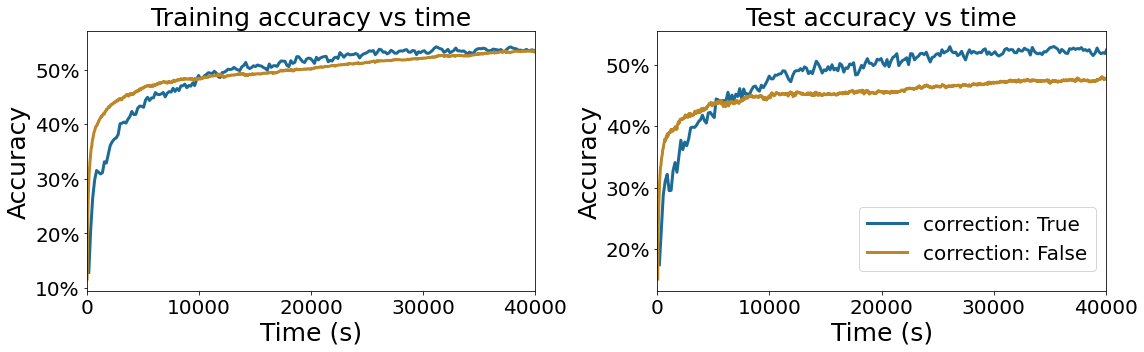

In [1355]:
num_x =2
num_y = 1
avg_time_dict = None
xlabel = ''
ylabel = ''
title  = ''
xlim=[0,40000]
ylim = [20,80.]
xlabel = 'Epochs'
lw = 3.
ynames = ['train_upper_acc','test_upper_acc']
title_names = ['Training accuracy vs time','Test accuracy vs time']
y_names = ['Accuracy','Accuracy']
gen_list = make_gens(list_config_dicts,ynames,group_keys,xname='time')
fig, ax = plt.subplots(num_y,num_x, figsize=(8*num_x,5*num_y))
for i,(gen,title_name,y_name) in enumerate(zip(gen_list,title_names,y_names)):
    plot_from_config(ax[i],
                 gen,
                 color_dict,
                 labels_dict,
                 linestyles_dict,
                 xscale='linear',
                 yscale = 'linear',
                 ylabel=y_name,
                 xlabel= 'Time (s)',
                 title= title_name ,
                 fontsize=25,
                 xlim=xlim,
                 ylim= None,
                 ticks_fontsize=20,
                 lw=lw,
                 with_legend=False)



vals = ax[1].get_yticks()
ax[1].set_yticklabels(['{:,.0%}'.format(x/100.) for x in vals])
vals = ax[0].get_yticks()
ax[0].set_yticklabels(['{:,.0%}'.format(x/100.) for x in vals])

handles, labels = ax[0].get_legend_handles_labels()
ax[1].legend(loc='center right', bbox_to_anchor=(1, 0.2),prop={"size":20})



plt.tight_layout()





fig_name = 'distillation_cifar10'
save(fig_name)


In [1356]:
max(gen_list[0][1]['y'])

54.34305205637095

In [1381]:
log_name = 'toy_sin'
out_dir = '../data/outputs'
reader = load_method(log_name,out_dir)

query = {'training.lower.objective.with_sin': [True],
         'selection.warm_start_iter':[0]}
out = reader.search(query)


query = {'training.lower.objective.with_sin': [True],
         'selection.warm_start_iter':[1],
        'selection.correction':[True]}
#out+=reader.search(query)


#color_dict, labels_dict, linestyles_dict,colors = make_plot_dicts(out)
len(out)

9

In [1382]:
val_keys = ['train_upper_loss','test_upper_loss']
failed_exps = []
for i,p in enumerate(out):
    add_res_to_data(p, val_keys, mode='last')
#        failed_exps.append(i)

out = [p  for i,p in enumerate(out) if i not in  failed_exps]


group_keys = [('selection','correction'), ('selection', 'warm_start_iter'),('selection', 'unrolled_iter'), ]

#group_keys = [('selection','optimizer','lr')]
#variable_keys = [('data','b_size')]
variable_keys = [('training','total_epoch')]
variable_keys = [('training','lower','model','name')]

#variable_keys = [('solver','inner_forward','n_iter')]

value_keys = [('results','train_upper_loss'), ('results','test_upper_loss')]
apply_func = [safeargmin,safeargmin]
aggregate_dict = aggregate_res_dict(out,group_keys, variable_keys, value_keys)
reduced_dict = reduce_res_dict(aggregate_dict, apply_func,variable_keys,sort=True, is_index=True)
list_config_dicts = reduced_dict_to_list_dicts(reduced_dict, 0, 'index_results_'+value_keys[1][1])
#methods = reduced_dict.keys()
#key_name = '-'.join([el[-1] for el in group_keys])+':'

#color_dict, labels_dict, linestyles_dict,colors = make_plot_dicts(methods,key_name)


In [1380]:
aggregate_dict['True_0_10']['examples.toy.models.Identity']

{'values': {'results_train_upper_loss': [-3.589782863855362e-05,
   1.5428289771080017e-05,
   3.087799996137619e-05],
  'results_test_upper_loss': [4.042554155053999e-14,
   8.12670264184239e-17,
   3.233259324343641e-16]},
 'vars': {'training_lower_model_name': 'examples.toy.models.Identity'},
 'refs': {'results_train_upper_loss': [{'cluster': {'cleanup': 'source gpu_setVisibleDevices.sh',
     'cmd': 'oarsub -S',
     'conda_env': 'default',
     'directive': '#OAR',
     'engine': 'OAR',
     'launchers': 'default',
     'name': 'thoth',
     'shell': {'bin_path': '/bin/bash', 'config_path': '~/.bashrc'},
     'user': 'marbel'},
    'launcher': {'besteffort': False,
     'cmd': 'run.py',
     'cpus': 1,
     'filename': 'default.sh',
     'gpumem': None,
     'gpumodel': None,
     'hours': 12,
     'idempotent': False,
     'name': 'default',
     'nodes': 1},
    'logs': {'log_dir': 'data/outputs',
     'log_id': 1,
     'log_name': 'toy_sin',
     'log_to_file': False,
     'pat

In [1360]:
labels_dict, linestyles_dict

({'True_0_10': 'correction-warm_start_iter-unrolled_iter: True_0_10',
  'False_0_100': 'correction-warm_start_iter-unrolled_iter: False_0_100',
  'False_0_1000': 'correction-warm_start_iter-unrolled_iter: False_0_1000',
  'False_0_1': 'correction-warm_start_iter-unrolled_iter: False_0_1',
  'True_0_1': 'correction-warm_start_iter-unrolled_iter: True_0_1',
  'False_0_10': 'correction-warm_start_iter-unrolled_iter: False_0_10'},
 {'True_0_10': '-',
  'False_0_100': '-',
  'False_0_1000': '-',
  'False_0_1': '-',
  'True_0_1': '-',
  'False_0_10': '-'})

In [1361]:
labels_dict = {'True': 'with correction', 'False': 'without correction'}

labels_dict = {'True_0_10': 'With Corr, $N{=}10$',
  'False_0_10': 'Without Corr, $N=10$',
  'True_0_1': 'With Corr, $N=1$',
  'False_0_1': 'Without Corr, $N=1$',
  'True_1_0': 'With Corr, $M=1$',
   'False_0_100': 'Without Corr, $N=100$',
  'False_0_1000': 'Without Corr, $N=1000$',}

linestyles_dict= {'True_0_10': '-',
  'False_0_10': '-.',
  'True_0_1': '-',
  'False_0_1': '-.',
  'True_1_0': '-',
  'False_0_100': '-.',
  'False_0_1000': '-.',}


#linestyles_dict

In [1362]:
#gen_list[0][1]['key']

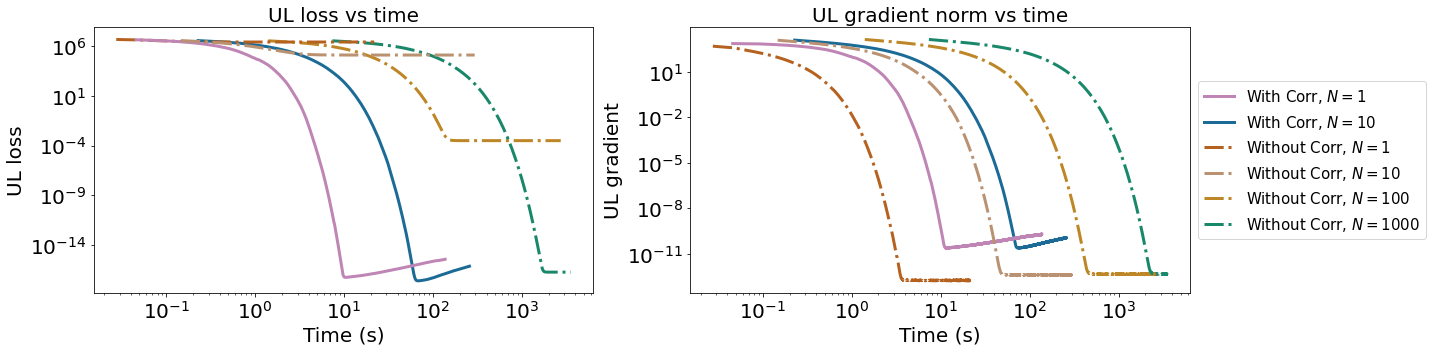

In [1363]:
num_x =2
num_y = 1
avg_time_dict = None
xlabel = ''
ylabel = ''
title  = ''
xlim= None#[0,300]
ylim = [20,80.]
xlabel = 'Epochs'
lw = 3.
ynames = ['test_upper_loss','upper_grad_norm']
title_name = ['UL loss vs time','UL gradient norm vs time']
y_name = ['UL loss','UL gradient']
gen_list = make_gens(list_config_dicts,ynames,group_keys,xname='time')
fig, ax = plt.subplots(num_y,num_x, figsize=(10*num_x,5*num_y))
for i,(gen,titlename,yname) in enumerate(zip(gen_list,title_name,y_name)):
    plot_from_config(ax[i],
                 gen,
                 color_dict,
                 labels_dict,
                 linestyles_dict,
                 xscale='log',
                 yscale = 'log',
                 ylabel=yname,
                 xlabel= 'Time (s)',
                 title= titlename ,
                 fontsize=20,
                 xlim=xlim,
                 ylim= None,
                 ticks_fontsize=20,
                 lw=lw,
                 with_legend=False)



vals = ax[1].get_yticks()
#ax[1].set_yticklabels(['{:,.0%}'.format(x/100.) for x in vals])
vals = ax[0].get_yticks()
#ax[0].set_yticklabels(['{:,.0%}'.format(x/100.) for x in vals])

handles, labels = ax[0].get_legend_handles_labels()
labels, handles = zip(*sorted(zip(labels, handles)))
ax[1].legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5),prop={"size":15})

#ax[1].legend(loc='center right', bbox_to_anchor=(1, 0.2),prop={"size":15})


plt.tight_layout()





fig_name = 'toy_sin'
save(fig_name)


In [1364]:
log_name = 'toy_sin'
out_dir = '../data/outputs'
reader = load_method(log_name,out_dir)

query = {'training.lower.objective.with_sin': [False],
         'selection.warm_start_iter':[0]}
out = reader.search(query)


query = {'training.lower.objective.with_sin': [False],
         'selection.warm_start_iter':[1],
        'selection.correction':[True]}
#out+=reader.search(query)


#color_dict, labels_dict, linestyles_dict,colors = make_plot_dicts(out)
len(out)

9

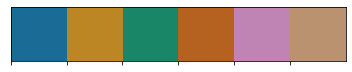

In [1365]:
val_keys = ['train_upper_loss','test_upper_loss']
failed_exps = []
for i,p in enumerate(out):
    add_res_to_data(p, val_keys, mode='last')
#        failed_exps.append(i)

out = [p  for i,p in enumerate(out) if i not in  failed_exps]


group_keys = [('selection','correction'), ('selection', 'warm_start_iter'),('selection', 'unrolled_iter'), ]

#group_keys = [('selection','optimizer','lr')]
#variable_keys = [('data','b_size')]
variable_keys = [('training','total_epoch')]
variable_keys = [('training','lower','model','name')]

#variable_keys = [('solver','inner_forward','n_iter')]

value_keys = [('results','train_upper_loss'), ('results','test_upper_loss')]
apply_func = [safeargmin,safeargmin]
aggregate_dict = aggregate_res_dict(out,group_keys, variable_keys, value_keys)
reduced_dict = reduce_res_dict(aggregate_dict, apply_func,variable_keys,sort=True, is_index=True)
list_config_dicts = reduced_dict_to_list_dicts(reduced_dict, 0, 'index_results_'+value_keys[1][1])
methods = reduced_dict.keys()
key_name = '-'.join([el[-1] for el in group_keys])+':'

_, labels_dict, linestyles_dict,_ = make_plot_dicts(methods,key_name)


In [1366]:
labels_dict

{'False_0_100': 'correction-warm_start_iter-unrolled_iter: False_0_100',
 'False_0_1000': 'correction-warm_start_iter-unrolled_iter: False_0_1000',
 'False_0_1': 'correction-warm_start_iter-unrolled_iter: False_0_1',
 'True_0_1': 'correction-warm_start_iter-unrolled_iter: True_0_1',
 'True_0_10': 'correction-warm_start_iter-unrolled_iter: True_0_10',
 'False_0_10': 'correction-warm_start_iter-unrolled_iter: False_0_10'}

In [1367]:
labels_dict = {'True': 'with correction', 'False': 'without correction'}

labels_dict = {'True_0_10': 'With Corr, $T{=}10$',
  'False_0_10': 'Without Corr, $T=10$',
  'True_0_1': 'With Corr, $T=1$',
  'False_0_1': 'Without Corr, $T=1$',
  'True_1_0': 'With Corr, $M=1$',
   'False_0_100': 'Without Corr, $T=100$',
  'False_0_1000': 'Without Corr, $T=1000$',}

linestyles_dict= {'True_0_10': '-',
  'False_0_10': '-.',
  'True_0_1': '-',
  'False_0_1': '-.',
  'True_1_0': '-',
  'False_0_100': '-.',
  'False_0_1000': '-.',}


#linestyles_dict

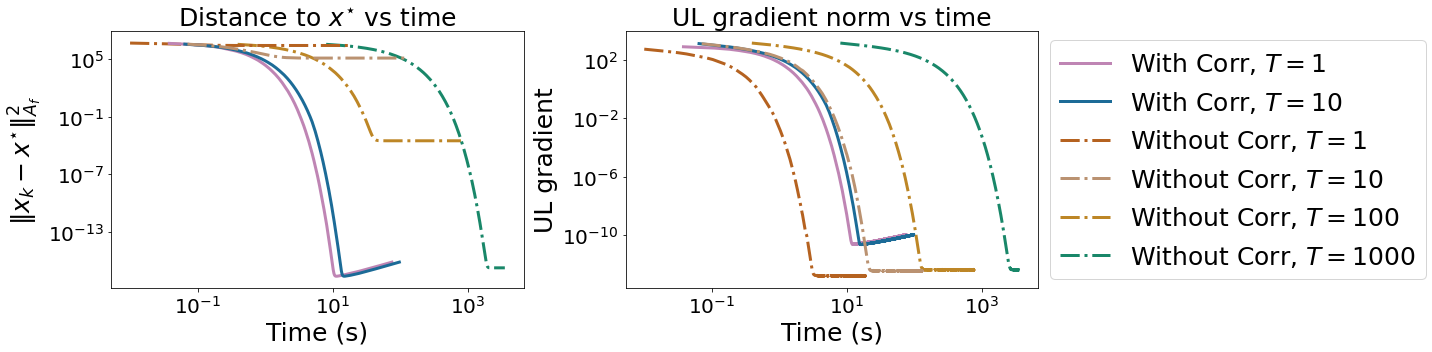

In [1368]:
num_x =2
num_y = 1
avg_time_dict = None
xlabel = ''
ylabel = ''
title  = ''
xlim= None#[0,300]
ylim = [20,80.]
xlabel = 'Epochs'
lw = 3.
ynames = ['test_upper_loss','upper_grad_norm']
title_name = ['Distance to $x^{\star}$ vs time','UL gradient norm vs time']
y_name = ['$\Vert x_k-x^{\star}\Vert^2_{A_f}$','UL gradient']
gen_list = make_gens(list_config_dicts,ynames,group_keys,xname='time')
fig, ax = plt.subplots(num_y,num_x, figsize=(10*num_x,5*num_y))
for i,(gen,titlename,yname) in enumerate(zip(gen_list,title_name,y_name)):
    plot_from_config(ax[i],
                 gen,
                 color_dict,
                 labels_dict,
                 linestyles_dict,
                 xscale='log',
                 yscale = 'log',
                 ylabel=yname,
                 xlabel= 'Time (s)',
                 title= titlename ,
                 fontsize=25,
                 xlim=xlim,
                 ylim= None,
                 ticks_fontsize=25,
                 lw=lw,
                 with_legend=False)



vals = ax[1].get_yticks()
#ax[1].set_yticklabels(['{:,.0%}'.format(x/100.) for x in vals])
vals = ax[0].get_yticks()
#ax[0].set_yticklabels(['{:,.0%}'.format(x/100.) for x in vals])

handles, labels = ax[0].get_legend_handles_labels()
labels, handles = zip(*sorted(zip(labels, handles)))
ax[1].legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5),prop={"size":25})

#ax[1].legend(loc='center right', bbox_to_anchor=(1, 0.2),prop={"size":15})


plt.tight_layout()





fig_name = 'toy_quad'
save(fig_name)


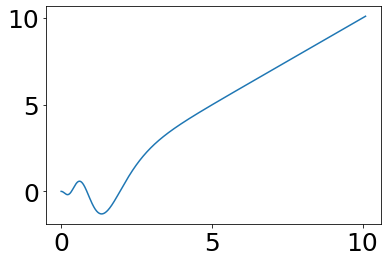

In [1369]:
b =.1 
x_0 = np.linspace(0,b+10,100000)
y = (2*x_0-10)**2
y= x_0
a=10
c =1
x = np.cos(a*np.exp(-(y-b)))*y
#x = -np.sin(a*y) + y
u = a*np.exp(-(y-b))

#x = np.sqrt((y-10.)**2+ 1.)

plt.plot(x_0,x)

#plt.plot(x_0,z)
#plt.title("Evolution of the function $h(x)$")
plt.title

fig_name = 'non_convex_function'
save(fig_name)

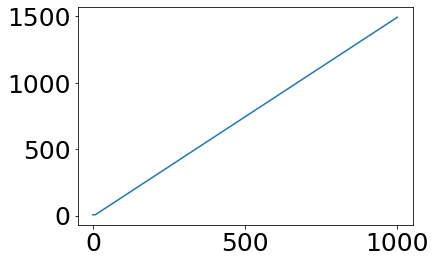

In [1370]:
x_0 = np.linspace(0.,1000,100000)
y = (2*x_0-10)**2
y= x_0
eps = 0.01
x = np.sqrt((y-1.)**2+eps) -0.5*np.sqrt((y-5.)**2+eps) + 0.5*np.sqrt((y-7.)**2+eps) + 0.5*np.sqrt((y-8.)**2+eps)

plt.plot(x_0,x)